In [4]:
import sys
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv
from matplotlib import pyplot
from tyssue.solvers import QSSolver

from IPython.display import Image


from tyssue.topology import add_vert


from tyssue import config, Sheet, SheetGeometry, History, EventManager, PlanarGeometry
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

### T1 transitions

from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

collision solver could not be imported You may need to install CGAL and re-install tyssue
C++ extension are not available for this version


In [5]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    
    cellmap.edge_df['length_elasticity_ECM'] = cellmap.edge_df['length_elasticity']
    cellmap.edge_df['length_elasticity_FRC'] = cellmap.edge_df['length_elasticity']
        
    for edge in range(len(cellmap.edge_df)):
        FRC = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECM = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRC + ECM
        cellmap.edge_df['length_elasticity_ECM'][edge] = ECM
        cellmap.edge_df['length_elasticity_FRC'][edge] = FRC
    return cellmap

In [6]:
def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
    for face in range(len(cellmap.face_df)):
        newValue = random.randrange(lower_prefered_area, higher_prefered_area)/10000
        cellmap.face_df['prefered_area'][face] = newValue
    return cellmap

In [7]:
def change_specs(cellmap, geom, model, history, face_elasticity,
                 lower_prefered_area, higher_prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought, endTime):
    
    
    length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)
    prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area)

    
    cellmap.face_df["face_elasticity"] = face_elasticity
    cellmap.edge_df["prefered_length"] = line_nought


    cellmap.vert_df["viscosity"] = 1   
    
    #cellmap_original.face_df["prefered_area"][0] = 2
    #cellmap_original.face_df["prefered_area"][41] = 2
    
    solver1 = EulerSolver(cellmap, geom, model, history=history, auto_reconnect=True)
    res1 = solver1.solve(tf=endTime, dt=0.05, on_topo_change=on_topo_change,
                   topo_change_args=(solver1.eptm,))
    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]
    

In [ ]:
## Definition of the sheet
geom_original  = SheetGeometry
model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

cellmap_original = Sheet.planar_sheet_3d('cellmap', 10, 10, 1, 1) # This may need to change

history_original = History(cellmap_original,
                           extra_cols={"edge":["dx", "dy"]})


cellmap_original.sanitize ( trim_borders=True, order_edges=True )

geom.update_all(cellmap_original)

cellmap_original.update_specs(model_original.specs)

fig, ax = sheet_view(cellmap_original, ['y', 'x'], mode='quick')

In [ ]:
fig, ax = sheet_view(cellmap_original, ['y', 'x'])
fig.set_size_inches(10, 10)

for face, data in cellmap_original.face_df.iterrows():
    ax.text(data.y, data.x, face, fontsize=7, color="r")

In [42]:
sheet = Sheet.planar_sheet_2d('flat', 10, 10, 1, 1, noise=0.2)
geom = PlanarGeometry()

sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
sheet.update_rank()
model = model_factory(
    [
        effectors.LengthElasticity,
        
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "length_elasticity": 1e-2,
        "prefered_length": 1,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Reseting column is_active of the vert dataset with new specs


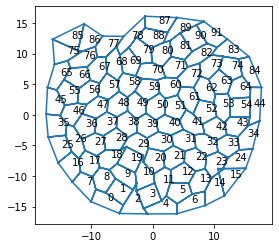

In [43]:
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet, mode="quick")
for f, (x, y) in sheet.face_df[["x", "y"]].iterrows():
    ax.text(x, y, f)

In [ ]:
cellmap_original.edge_df

In [ ]:
type1_transition(cellmap_original, 0, multiplier=6)
cellmap_original.reset_index()

geom.update_all(cellmap_original)

fig, ax = plot_forces(cellmap_original, geom_original, model_original, ['x', 'y'], 1)

fig.set_size_inches(10, 10)
for face, data in cellmap_original.face_df.iterrows():
    ax.text(data.x, data.y, face)

for vert, data in cellmap_original.vert_df.iterrows():
    ax.text(data.x, data.y+0.1, vert)

In [ ]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity = 5, lower_prefered_area = 10, higher_prefered_area = 10000, 
                                                       FRC_lower_length_elasticity = 10, FRC_higher_length_elasticity = 1000, ECM_lower_length_elasticity = 10, 
                                                       ECM_higher_length_elasticity = 1000, line_nought = 0.01 , endTime = 10)

In [ ]:
fig, ax = sheet_view(cellmap_H, ['y', 'x'])
fig.set_size_inches(10, 10)